# Setup

In [ ]:
!git clone https://github.com/IgnacioOQ/vaccine_ethics
%cd vaccine_ethics

Cloning into 'vaccine_ethics'...
remote: Enumerating objects: 158, done.
remote: Counting objects: 100% (158/158), done.
remote: Compressing objects: 100% (135/135), done.
remote: Total 158 (delta 84), reused 61 (delta 22), pack-reused 0 (from 0)
Receiving objects: 100% (158/158), 1.23 MiB | 8.25 MiB/s, done.
Resolving deltas: 100% (84/84), done.
/content/vaccine_ethics


In [ ]:
from imports import *
from agent_class import FullAgent
from simulation_class import Simulation

In [ ]:
!pip install scikit-optimize

from joblib import Parallel, delayed
from multiprocessing import cpu_count
from skopt import Optimizer
from skopt.space import Real
from skopt.plots import plot_convergence
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import plotly.express as px
import os
import time
import math


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 2.8 MB/s eta 0:00:00


In [ ]:
print(f"Number of available CPU cores: {os.cpu_count()}")

Number of available CPU cores: 96


In [ ]:
# Decide where to put the files and do the working
from google.colab import drive
drive.mount('/content/drive')

dump_path = '/content/drive/My Drive/Colab Projects/Vaccine Ethics/'
print("Current Directory:", dump_path)


Mounted at /content/drive
Current Directory: /content/drive/My Drive/Colab Projects/Vaccine Ethics/


# Testing

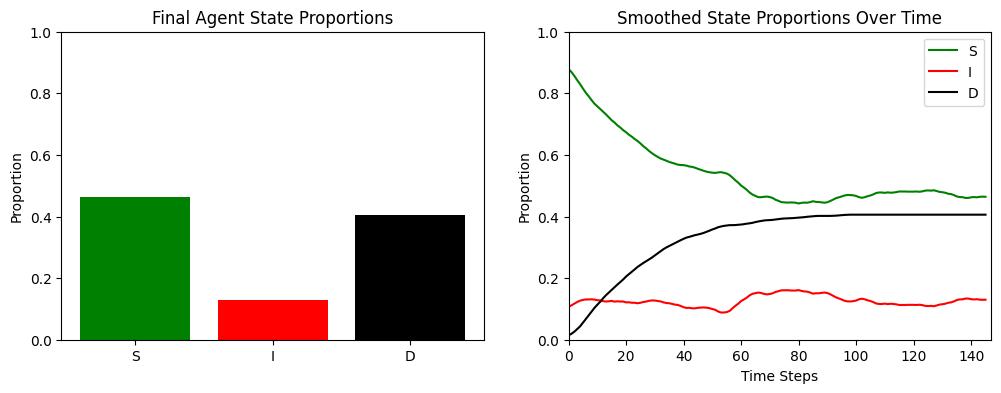

,step,dead_proportion,max_infected,auc_infected,avg_viral_age,avg_immunity,non_vul_prop_dead
0,145.0,0.406,0.166,18.244,9.566,1.018,0.43459


In [ ]:
simulation_results = pd.DataFrame(columns=["step", "dead_proportion", "max_infected", "auc_infected", "avg_viral_age", "avg_immunity","non_vul_prop_dead"])

simulation = Simulation(grid_size=25, num_agents=500, agent_class = FullAgent, init_infected_proportion = 0.1,
                 proportion_vulnerable=0.1, vul_penalty = 0.2,
                 infection_prob=0.25, recovery_time=30, death_prob=0.1,
                 vax_vulnerable=False,
                 vax_all=False,
                 vax_effect = 0.7,
                 viral_age_effect = 0.1,
                 immune_adaptation_effect = 0.1,
                 plot=True)
simulation.run(500)  # Run for 20 iterations
# simulation.plot_hist()
results = simulation.generate_simulation_report()
simulation_results.loc[len(simulation_results)] = results
# simulation_results = pd.concat([simulation_results, results], ignore_index=True)
simulation_results

In [ ]:
results[1]

np.float64(0.406)

# Bayesian Optimization with Parallelization (and n_trials)

## Parameters

In [ ]:
# --- Fixed Parameters ---
grid_size = 25
num_agents = 500
init_infected_proportion = 0.1
proportion_vulnerable = 0.1
recovery_time = 30

fixed_infection_prob = 0.25
fixed_immune_adaptation_effect = 0.05
fixed_vul_penalty = 2

# --- Search Space (reduced) ---
space = [
    Real(0.01, 0.9, name='death_prob'),
    Real(0.1, 0.9, name='vax_effect'),
    Real(0.1, 0.9, name='viral_age_effect')]

## Functions

### Main Function

In [ ]:

# --- Averaged Simulation Runner ---
def average_simulation_metrics(params, n_trials, inner_workers=None):
    """Runs simulation n_trials times in parallel and returns averaged metrics."""
    if n_trials < 1:
        raise ValueError("n_trials must be at least 1.")

    inner_workers = inner_workers or min(cpu_count(), n_trials)

    trial_results = Parallel(n_jobs=inner_workers, backend="threading")(
        delayed(run_simulation_for_params)(params) for _ in range(n_trials)
    )

    avg_result = {}
    keys = trial_results[0].keys()

    for key in keys:
        values = [res[key] for res in trial_results]
        if isinstance(values[0], (float, int)):
            avg_result[key] = np.mean(values)
        else:
            avg_result[key] = values[0]  # Preserve params or other non-numeric values

    return avg_result



def run_simulation_for_params(params):
    """Evaluate harm caused (or prevented) by vaccinating all vs vulnerable-only."""
    results = {}
    for vax_all in [True, False]:
        simulation = Simulation(
            grid_size=grid_size,
            num_agents=num_agents,
            agent_class=FullAgent,
            init_infected_proportion=init_infected_proportion,
            proportion_vulnerable=proportion_vulnerable,
            vul_penalty=fixed_vul_penalty,
            infection_prob=fixed_infection_prob,
            recovery_time=recovery_time,
            death_prob=params[0],
            vax_vulnerable=True,
            vax_all=vax_all,
            vax_effect=params[1],
            viral_age_effect=params[2],
            immune_adaptation_effect=fixed_immune_adaptation_effect,
            plot=False
        )
        simulation.run()
        report = simulation.generate_simulation_report()
        results[vax_all] = {
            'steps': report[0],
            'deaths': report[1],
            'auc_infected': report[3],
            'avg_viral_age': report[4],
            'avg_immunity': report[5],
            'non_vul_proportion_dead': report[6],
            'vulnerable_proportion_dead': report[7],
            'seed': report[8]  # Store the seed for reproducibility
        }

    harm = results[True]['deaths'] - results[False]['deaths']
    auc_diff = results[True]['auc_infected'] - results[False]['auc_infected']

    return {
        'harm': -harm,
        'deaths_vax': results[True]['deaths'],
        'deaths_no_vax': results[False]['deaths'],
        'steps_vax': results[True]['steps'],
        'steps_no_vax': results[False]['steps'],
        'auc_vax': results[True]['auc_infected'],
        'auc_no_vax': results[False]['auc_infected'],
        'delta_auc': auc_diff,
        'non_vul_proportion_dead_delta': results[True]['non_vul_proportion_dead'] - results[False]['non_vul_proportion_dead'],
        'vulnerable_proportion_dead_delta': results[True]['vulnerable_proportion_dead'] - results[False]['vulnerable_proportion_dead'],
        'viral_age_delta': results[True]['avg_viral_age'] - results[False]['avg_viral_age'],
        'immunity_delta': results[True]['avg_immunity'] - results[False]['avg_immunity'],
        'params': params,
        'seeds': (results[True]['seed'],results[False]['seed'])  # Store the seed for reproducibility
    }


# --- Parallel Evaluation ---
def parallel_objective(params_batch, progress_desc="Running Batch", num_workers=None, n_trials=5):
    """Parallelized wrapper for simulation trials per parameter set."""
    num_workers = num_workers or cpu_count()
    print(f"Using {num_workers} workers")


    results = Parallel(n_jobs=num_workers)(
    delayed(average_simulation_metrics)(params, n_trials) for params in tqdm(params_batch, desc=progress_desc)
)

    return results


# --- BO Runner ---
def run_bayesian_optimization(
    n_calls=300,
    n_initial_points=50,
    parallel_batch_size=50,
    num_workers=None,
    n_trials=5
):
    print(f"\n--- Running BO with n_trials={n_trials} for fixed immune_adaptation_effect={fixed_immune_adaptation_effect}, infection_prob={fixed_infection_prob}, vul_penalty={fixed_vul_penalty} ---")
    results_list = []

    def batch_objective(params_batch, desc):
        batch_results = parallel_objective(params_batch, desc, num_workers, n_trials=n_trials)
        for p, res in zip(params_batch, batch_results):
            results_list.append({
                'death_prob': p[0],
                'vul_penalty': fixed_vul_penalty,
                'vax_effect': p[1],
                'viral_age_effect': p[2],
                'immune_adaptation_effect': fixed_immune_adaptation_effect,
                'infection_prob': fixed_infection_prob,
                'vax_harm_score': res['harm'],
                'deaths_vax': res['deaths_vax'],
                'deaths_no_vax': res['deaths_no_vax'],
                'steps_vax': res['steps_vax'],
                'steps_no_vax': res['steps_no_vax'],
                'auc_vax': res['auc_vax'],
                'auc_no_vax': res['auc_no_vax'],
                'delta_auc': res['delta_auc'],
                'non_vul_proportion_dead_delta': res['non_vul_proportion_dead_delta'],
                'viral_age_delta': res['viral_age_delta'],
                'immunity_delta': res['immunity_delta'],
            })
        return [r['harm'] for r in batch_results]

    opt = Optimizer(
        dimensions=space,
        base_estimator="GP",
        acq_func="LCB",
        acq_func_kwargs={"kappa": 3.0},
        acq_optimizer="sampling",  # avoids repeat points
        random_state=42
    )


    # opt = Optimizer(dimensions=space, base_estimator="GP", acq_func="gp_hedge", random_state=42)

    initial_params = opt.ask(n_initial_points)
    batch_objective(initial_params, desc="Initial Random Sampling")
    opt.tell(initial_params, [r['vax_harm_score'] for r in results_list])

    num_batches = (n_calls - n_initial_points) // parallel_batch_size
    for i in tqdm(range(num_batches), desc="Bayesian Optimization Progress"):
        next_params = opt.ask(parallel_batch_size)
        batch_results = batch_objective(next_params, desc=f"Batch {i+1}/{num_batches}")
        opt.tell(next_params, batch_results)

    df_results = pd.DataFrame(results_list)
    df_results.to_csv(dump_path + 'bo_results_fixed_params.csv', index=False)
    print("Bayesian Optimization complete! Results saved to 'bo_results_fixed_params.csv'.")

    vax_hurts_df = get_vax_hurts_region(df_results)
    plot_3d_vax_hurts(df_results)
    plotly_3d_vax_hurts(df_results)
    return df_results, vax_hurts_df


# --- Harm Region Analysis ---
def get_vax_hurts_region(df_results):
    df_results['actual_diff'] = -df_results['vax_harm_score']
    hurts = df_results[df_results['actual_diff'] > 0]
    print(f"\nFound {len(hurts)} parameter sets where vaccination increased deaths.")
    hurts.to_csv(dump_path + 'vax_hurts_region.csv', index=False)
    return hurts


# # --- Plotting ---
def plot_3d_vax_hurts(df_results, filepath=None):
    df_results['actual_diff'] = -df_results['vax_harm_score']
    hurts_df = df_results[df_results['actual_diff'] > 0]

    if hurts_df.empty:
        print("No harmful vaccination outcomes found. Skipping 3D plot.")
        return

    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    x, y, z = hurts_df['death_prob'], hurts_df['vax_effect'], hurts_df['viral_age_effect']
    harm = hurts_df['actual_diff']
    norm = mcolors.Normalize(vmin=harm.min(), vmax=harm.max())
    colors = cm.Reds(norm(harm))

    ax.scatter(x, y, z, c=colors, marker='o', alpha=0.9)
    ax.set_xlabel('Death Probability')
    ax.set_ylabel('Vaccine Effectiveness')
    ax.set_zlabel('Viral Age Effect')
    ax.set_title('3D Region Where Vaccination Increased Deaths')

    mappable = cm.ScalarMappable(norm=norm, cmap=cm.Reds)
    mappable.set_array(harm)
    cbar = plt.colorbar(mappable, ax=ax, pad=0.1)
    cbar.set_label('Vaccination Harm (Δ deaths)')

    plt.tight_layout()
    filepath = filepath or dump_path + "vax_hurts_3d_plot.png"
    plt.savefig(filepath, dpi=300)
    print(f"Plot saved to {filepath}")
    plt.show()


def plotly_3d_vax_hurts(df_results, output_html=None):
    df_results['actual_diff'] = -df_results['vax_harm_score']
    hurts_df = df_results[df_results['actual_diff'] > 0]

    if hurts_df.empty:
        print("No harmful vaccination outcomes found. Skipping Plotly plot.")
        return

    fig = px.scatter_3d(
        hurts_df,
        x='death_prob',
        y='vax_effect',
        z='viral_age_effect',
        color='actual_diff',
        color_continuous_scale='Reds',
        title='Interactive 3D: Where Vaccination Increased Deaths',
        labels={'actual_diff': 'Vax Harm (Δ deaths)'},
        opacity=0.8
    )

    fig.update_traces(marker=dict(size=5))
    output_html = output_html or dump_path + "interactive_vax_hurts_plot.html"
    fig.write_html(output_html)
    print(f"Interactive 3D plot saved to '{output_html}'")
    fig.show()


## Run Optimization


--- Running BO with n_trials=200 for fixed immune_adaptation_effect=0.05, infection_prob=0.25, vul_penalty=2 ---
Using 96 workers


Bayesian Optimization Progress:   0%|          | 0/7 [00:00<?, ?it/s]

Using 96 workers



Bayesian Optimization Progress:  14%|█▍        | 1/7 [1:16:05<7:36:34, 4565.78s/it]

Using 96 workers



Bayesian Optimization Progress:  29%|██▊       | 2/7 [2:36:47<6:34:00, 4728.12s/it]

Using 96 workers



Bayesian Optimization Progress:  43%|████▎     | 3/7 [3:59:19<5:22:00, 4830.18s/it]

Using 96 workers



Bayesian Optimization Progress:  57%|█████▋    | 4/7 [5:27:34<4:10:41, 5013.97s/it]

Using 96 workers



Bayesian Optimization Progress:  71%|███████▏  | 5/7 [6:49:07<2:45:40, 4970.31s/it]

Using 96 workers



Bayesian Optimization Progress:  86%|████████▌ | 6/7 [8:38:13<1:31:46, 5506.04s/it]

Using 96 workers



Bayesian Optimization Progress: 100%|██████████| 7/7 [10:14:21<00:00, 5265.91s/it]


Bayesian Optimization complete! Results saved to 'bo_results_fixed_params.csv'.

Found 224 parameter sets where vaccination increased deaths.
Plot saved to /content/drive/My Drive/Colab Projects/Vaccine Ethics/vax_hurts_3d_plot.png


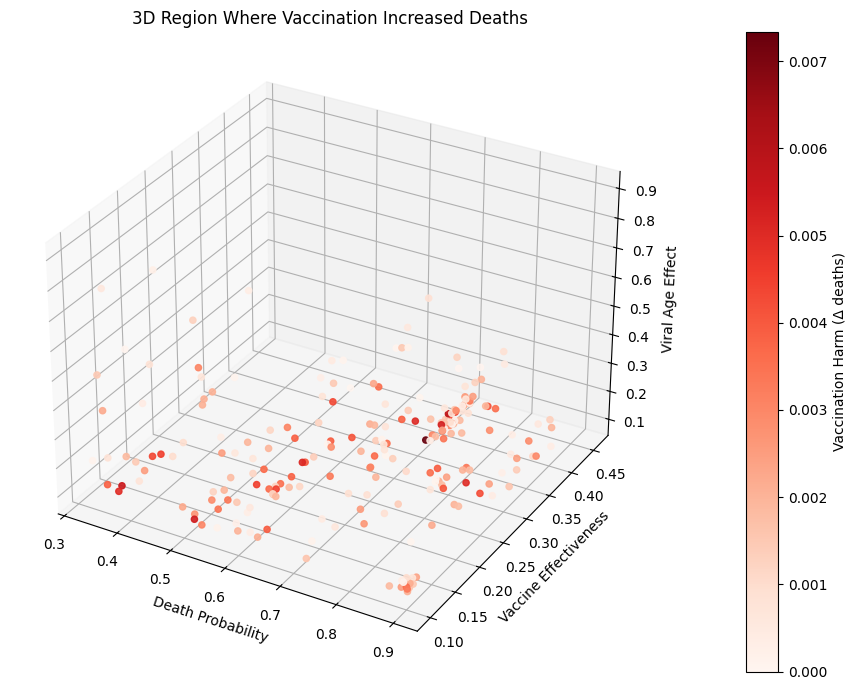

Interactive 3D plot saved to '/content/drive/My Drive/Colab Projects/Vaccine Ethics/interactive_vax_hurts_plot.html'


CPU times: user 4d 7h 23min 2s, sys: 11min 54s, total: 4d 7h 34min 56s
Wall time: 12h 44min 6s


In [ ]:
# --- Run Optimization ---
%%time
if __name__ == "__main__":
    df_results, vax_hurts_df = run_bayesian_optimization(
        n_calls=1000,
        n_initial_points=250,
        parallel_batch_size=100,
        num_workers=None,  # Use all cores
        n_trials=200
    )

In [ ]:
vax_hurts_df.head(10)

,death_prob,vul_penalty,vax_effect,viral_age_effect,immune_adaptation_effect,infection_prob,vax_harm_score,deaths_vax,deaths_no_vax,steps_vax,steps_no_vax,auc_vax,auc_no_vax,delta_auc,non_vul_proportion_dead_delta,viral_age_delta,immunity_delta,actual_diff
10,0.874969,2,0.103229,0.886317,0.05,0.25,-0.00007,0.11194,0.11187,63.770,63.100,9.753230,12.630120,-2.876890,0.000810,-0.63468,-0.10252,0.00007
13,0.895863,2,0.104044,0.111092,0.05,0.25,-0.00360,0.12841,0.12481,6.700,5.875,0.091880,0.075225,0.016655,0.003593,0.00289,0.00009,0.00360
48,0.899934,2,0.101583,0.102298,0.05,0.25,-0.00206,0.12430,0.12224,6.450,5.710,0.084655,0.071870,0.012785,0.001448,0.00089,0.00020,0.00206
77,0.893562,2,0.126398,0.104618,0.05,0.25,-0.00234,0.12804,0.12570,6.720,5.920,0.093980,0.078230,0.015750,0.000615,0.00122,0.00032,0.00234
88,0.898023,2,0.107503,0.104475,0.05,0.25,-0.00158,0.12644,0.12486,7.020,5.975,0.092880,0.076120,0.016760,0.001373,0.00243,0.00057,0.00158
96,0.893159,2,0.101201,0.130624,0.05,0.25,-0.00016,0.12504,0.12488,6.775,5.955,0.091640,0.075970,0.015670,0.000411,0.00008,0.00040,0.00016
108,0.893408,2,0.106599,0.110671,0.05,0.25,-0.00317,0.12646,0.12329,6.465,6.110,0.088380,0.075485,0.012895,0.001798,0.00070,0.00023,0.00317
128,0.893712,2,0.106334,0.137255,0.05,0.25,-0.00098,0.12812,0.12714,7.470,6.275,0.103200,0.101755,0.001445,0.000135,-0.01877,-0.00045,0.00098
135,0.899664,2,0.113078,0.107688,0.05,0.25,-0.00151,0.12632,0.12481,6.725,5.900,0.089105,0.075165,0.013940,0.000233,0.00169,0.00010,0.00151
151,0.898227,2,0.108279,0.117681,0.05,0.25,-0.00217,0.12792,0.12575,6.525,6.300,0.090385,0.078445,0.011940,0.001372,0.00136,0.00017,0.00217


## Plotting

Viral age effect stats:
count    224.000000
mean       0.252870
std        0.212513
min        0.100021
25%        0.105345
50%        0.149066
75%        0.363430
max        0.898813
Name: viral_age_effect, dtype: float64
Min value in viral_age_effect: 0.1000205972822579
Plot saved to /content/drive/My Drive/Colab Projects/Vaccine Ethics/vax_hurts_3d_plot.png


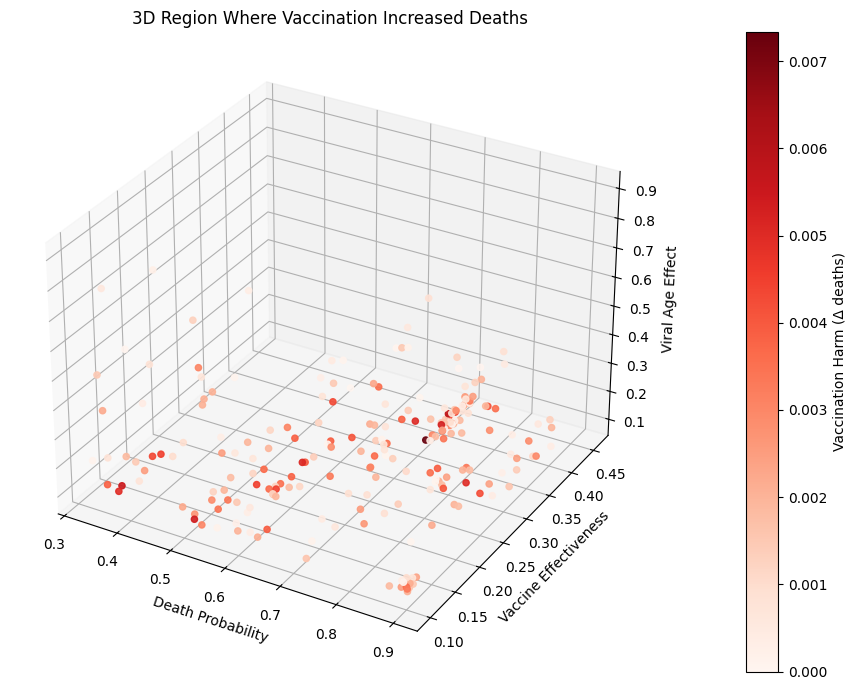

In [ ]:
hurts_df = df = pd.read_csv(dump_path + 'vax_hurts_region.csv')
x = hurts_df['death_prob']
y = hurts_df['vax_effect']
z = hurts_df['viral_age_effect']
print("Viral age effect stats:")
print(hurts_df['viral_age_effect'].describe())
print("Min value in viral_age_effect:", hurts_df['viral_age_effect'].min())
plot_3d_vax_hurts(hurts_df)